In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
from collections import defaultdict
#import generalized_hough

Utils for image processing

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def ycbcr(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10): 
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):    
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

def weighted_img(img, initial_img, a=0.8, b=1., g=0.):   
    return cv2.addWeighted(initial_img, a, img, b, g)

def erode(img, kernel = None, iterations=2):
    return cv2.erode(img, kernel, iterations)

def dilate(img, kernel = None, iterations=2):
    return cv2.dilate(img, kernel, iterations)

def draw_contour(image, cont, color=(0,255,0), thikness=2):
    cv2.drawContours(image,[cont],0,color,thikness)
    
def normalize(data):
    return np.float32(data) / np.max(data)
    

In [3]:
def sharpen(image, alpha = 1.0, strength = 1.0):
    matrix_no_change = np.float32([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    matrix_effect    = np.float32([[-1,-1,-1], [-1, 8 + strength,-1], [-1,-1,-1]])

    matrix  = (1 - alpha) * matrix_no_change + alpha * matrix_effect
    result = cv2.filter2D(image, -1, matrix)
    return result

def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    for line in lines:
        #line = line[0]
      
        if len(line) < 1:
            continue
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_lines_image(shape, lines):
    line_img = np.zeros((shape), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def find_countours(thresholded):
    image, countours, hierarchies = cv2.findContours(thresholded, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    return countours

Functions for image segmentation: 

- color clustering (3 classes green, ground, others)
- pyramid mean shift (remove lightening -> http://stackoverflow.com/questions/4831813/image-segmentation-using-mean-shift-explained)
- excess green (from here -> http://www.etfos.unios.hr/r3dvgroup/index.php?id=crop-row-detection)

In [4]:
def color_cluster(img):
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    ret,label,center=cv2.kmeans(Z,K,None,criteria,15,cv2.KMEANS_RANDOM_CENTERS )

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2, center

def pyramid_mean_shift(img): #explanation: http://stackoverflow.com/questions/4831813/image-segmentation-using-mean-shift-explained
    trm_crit = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    return cv2.pyrMeanShiftFiltering(img, sp=4, sr=4, maxLevel=4, termcrit=trm_crit )

def excess_green(image):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return 2*G - R - B

Load image

In [5]:
folder = '/home/taras/Downloads/CRBD/Images/'
im_path = os.path.join(folder, 'crop_row_001.JPG')

image = cv2.imread(im_path)
#image = cv2.GaussianBlur(image, (5, 5), 2, 2)

Different versions of image preprocessing

In [10]:
#processed, center = color_cluster(image)
#processed = pyramid_mean_shift(image)
processed = excess_green(image)
ret,thresholded = cv2.threshold(processed,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

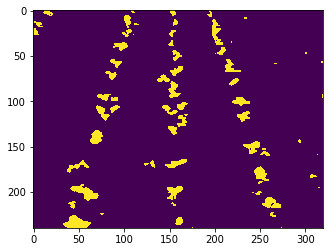

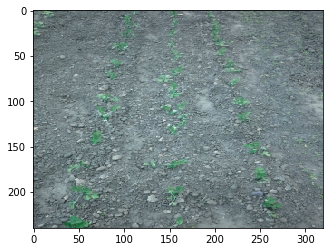

In [11]:
plt.imshow(thresholded)
plt.show()

plt.imshow(image)
plt.show()

How image segmentation by color works

In [70]:
image = cv2.GaussianBlur(image, (5, 5), 2, 2)

In [289]:
def segment_image(image, target_color):
    rgb = np.zeros((image.shape), dtype=np.uint8)
    print (rgb.shape)

    rgb[:, :, 0] = np.uint8(image[:, :, 2] == target_color[0]) * 255
    rgb[:, :, 1] = np.uint8(image[:, :, 1] == target_color[1]) * 255
    rgb[:, :, 2] = np.uint8(image[:, :, 0] == target_color[2]) * 255
    
    return rgb

In [290]:
clustered, center = color_cluster(image)

(194, 259, 3)
(194, 259, 3)
(194, 259, 3)
(194, 259, 3)


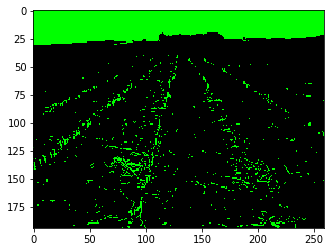

In [294]:
for cl in center:
    segmented = segment_image(clustered, cl)
    #plt.imshow(segmented)
    #plt.show()
segmented = segment_image(clustered, center[1])
plt.imshow(segmented)
plt.show()

Finding structural elemens (closing, opening)

In [79]:
#eroded = erode(segmented, cv2.getStructuringElement(cv2.MORPH_RECT, (11,11)), 4)

gray = grayscale(segmented)
#edges = canny(gray, 10, 50)

#se1 = cv2.getStructuringElement(cv2., (15,15))
se2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

#se1 = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0], [1, 1, 1, 1, 1]], dtype=np.uint8)
mask = gray
#se1 = np.ones((9, 9), dtype=np.uint8)
#se2 = np.ones((15, 15), dtype=np.uint8)
#for i in range(1):
#mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se1)
#mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se1)
#mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

#mask = erode(segmented, None, 1)
mask = dilate(mask, se2, 1)

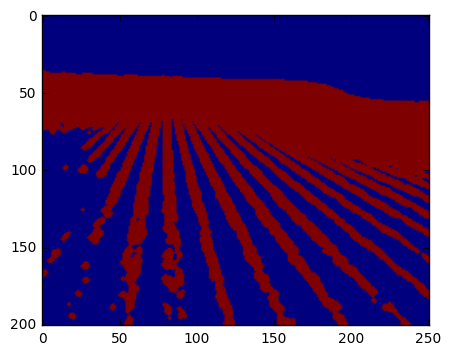

In [80]:
#mask = mask[50:100, :]

plt.imshow(mask)
plt.show()

In [126]:
#kernel = np.ones((3,3),np.uint8)

#krn = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1) )

#krn2 = np.array([[0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0]], dtype=np.uint8)
#dilated = erode(segmented, krn, 1)
#opening = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, krn)
#opening = gaussian_blur(segmented, 7)
#opening = dilate(opening, krn, 2)
#dilated = opening[:, :, 0]#erode(opening, kernel, 1)
#opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)
#dilated = erode(opening, kernel, 1)
#edges = canny(image[:, :, 0], 0, 125)
#opening = segmented
#edges = dilate(edges, None, 1)

#dx = cv2.Sobel(opening,cv2.CV_64F,1,0,ksize=3)

Finding contours

In [174]:
gray = grayscale(mask)

contours = find_countours(gray)

(0, 50)


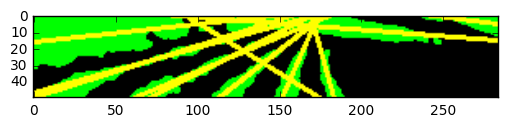

(50, 100)


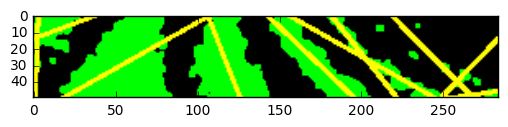

(100, 150)


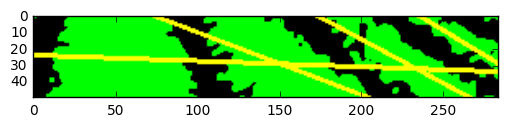

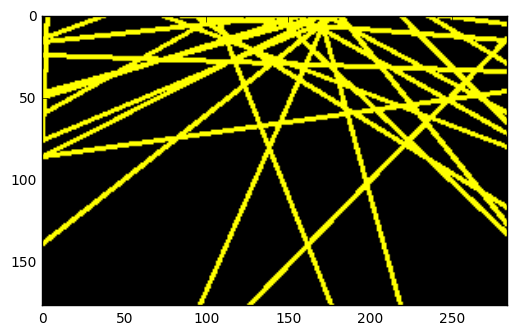

In [212]:
src = image.copy()#[50:100, :]
rows,cols = src.shape[:2]

step = 50
res = np.zeros((image.shape), dtype=np.uint8)
for i in range(0, src.shape[0] - step, step):
    print (i, i+step)
    ex_mask = mask[i:i + step]
    gray = grayscale(ex_mask)
    contours = find_countours(gray)
    ex_src = src[i:i + step]
    rows,cols = res.shape[:2]
    rows1,cols1 = ex_mask.shape[:2]
    for cnt in contours:
        if cv2.contourArea(cnt) > 20 :
            #print (cv2.contourArea(cnt))
            #epsilon = 0.04*cv2.arcLength(cnt,True)
            #approx = cv2.approxPolyDP(cnt,epsilon,True)
            #if len(approx) < 18:
            #draw_contour(src, approx)
        
            [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
            #print (vx,vy,x,y)
            lefty = int((-x*vy/vx) + y)
            righty = int(((cols-x)*vy/vx)+y)
            #print (lefty, righty)
            #if lefty > 0 and righty > 0:
            cv2.line(res,(cols-1,righty),(0,lefty),(255,255,0),2)
            
            righty = int(((cols1-x)*vy/vx)+y)
            cv2.line(ex_mask,(cols1-1,righty),(0,lefty),(255,255,0),2)
            
    plt.imshow(ex_mask)
    plt.show()

    
plt.imshow(res)
plt.show()

In [13]:
def vector(a, b): #creates vector from two points
    return [a[0] - b[0], a[1] - b[1]]

def distance(vec): #measures magnitude of vector
    return (vec[0]**2 + vec[1]**2)**0.5

def normalized(a, b):
    dx, dy = vector(a, b)
    mg = distance([dx, dy])
    coef = 1.0 / mg
    return [float(dx) * coef,float(dy) * coef]

def dot(a, b): #element wise multiplication with sum of two vectors
    return a[0] * b[0] + a[1] * b[1]

def is_vertical(line):
    x1, y1, x2, y2 = line
    
    a = vector((x1, y1), (x2, y2))
    b = vector((0, 0), (0,10))
    
    ad = distance(a)
    
    angle = get_angle(a, b) 
    
    return abs(angle) < 30 #and ad > 50
    
def get_angle(a, b): #getting angle between three points
    
    #a = vector(far, start)
    #b = vector(far, end  )
    ab = dot(a, b)
    dist_ab = distance(a) * distance(b) 
    
    calc = min(max((ab / dist_ab), -1.0), 1.0)   
    
    angle = math.acos(calc) * 180 / math.pi
    return angle

def clean_lines(lines):
    new_lines = []
    for line in lines:
        if (is_vertical(line[0])):
             new_lines.append(line)
            
    return new_lines

Hough lines tries

In [15]:
def get_lines(edges, rho, theta, threshold):

    lines = cv2.HoughLines(edges,rho,theta,threshold)
    
    line_img = np.zeros((edges.shape), dtype=np.uint8)
    
    if lines is None or len(lines) <= 0:
        return line_img
    
    print len(lines)
    #print lines[0]
    for ln in lines:
        for rho,theta in ln:
            #print len(lines)
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            #print (x1, y1, x2, y2)
            if (theta > 0 and theta < 0.5) or (theta > 2.2 and theta < 3.5): 
                if ((rho >-150 and rho < -123) or (rho < 130 and rho > 100)):# and rho < 30: #and rho < -90:
                    print rho, theta
                
                cv2.line(line_img,(x1,y1),(x2,y2),(255,255,255),1)
        
    return line_img

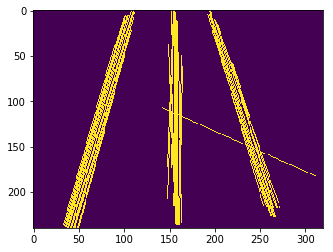

(240, 320, 3) (240, 320)


error: /home/taras/coder/OpenCV/modules/core/src/arithm.cpp:659: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [24]:

%matplotlib inline
from ipywidgets import *

@interact(rho =IntSlider(min=0, max=10, continuous_update=False, description="rho:" , value=1),
          theta=IntSlider(min=0, max=360, continuous_update=False, description="theta:",value=180),
          threshold =IntSlider(min=0, max=255, continuous_update=False, description="threshold:" , value=20),
          min_line_len =IntSlider(min=0, max=255, continuous_update=False, description="min_len:" , value=150),
          max_line_gap=IntSlider(min=0, max=255, continuous_update=False, description="max_gap:",value=80))


def find_lines(rho, theta,  threshold, min_line_len, max_line_gap):
        
    #gray = grayscale(dilated)
    #blured = gaussian_blur(gray, 5)
    
    #rho = 1 #distance resolution in pixels of the Hough grid
    theta = np.pi/theta #angular resolution in radians of the Hough grid
    #threshold = 20     #minimum number of votes (intersections in Hough grid cell)
    #min_line_len = 100 #minimum number of pixels making up a line
    #max_line_gap = 80    #maximum gap in pixels between connectable line segments
   
    lines = hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap)
    #scr = image.copy()
    #result = weighted_img(line_image, scr)
    
    #lines_image = get_lines(segmented[:, :, 0], rho, theta, threshold )#cv2.HoughLines(segmented[:, :, 0], rho, theta, threshold )
    #lines = hough_lines(mask[:, :, 0], rho, theta, threshold, min_line_len, max_line_gap)
    #lines = clean_lines(lines)
    #print (len(lines))
    lines_image = get_lines_image(mask.shape, lines)
    

    plt.imshow(lines_image)
    plt.show()
    
    print image.shape, lines_image.shape
    result = cv2.addWeighted(image.copy(), 0.8, lines_image, 1, 0)
    #result = weighted_img(lines_image, image.copy())
    
    plt.imshow(result.copy())
    plt.show()
    
